# Single column implementation

In [24]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
age_adult = pd.read_csv("./data/adult.csv")
age_adult = age_adult[["age"]]
age_adult.to_csv("./data/age-adult.csv", index=False) 

In [ ]:
from mbi import Dataset, FactoredInference, Domain, LocalInference, PublicInference
import numpy as np
from scipy import sparse

# load adult dataset

data = Dataset.load('./data/age-adult.csv', './data/age-adult-domain.json')
domain = data.domain
total = data.df.shape[0]

print(domain)

np.random.seed(0)

sigma = 1.0

measurements = []
for col in data.domain:
    # On récupère les données réelles
    x = data.project(col).datavector()
    # On perturbe les résultats réels
    y = x + np.random.laplace(loc=0, scale=sigma, size=x.size)
    I = sparse.eye(x.size)
    measurements.append( (I, y, sigma, (col,)) )

# On réalise l'inférence de la distribution perturbée en entrainant un modèle de machine learning
engine = FactoredInference(domain, log=True, iters=2500)

model = engine.estimate(measurements, total=total)

# On génère un jeu de données sythétique
synth_data = model.synthetic_data()
synth_data.df.head()

<Axes: xlabel='age', ylabel='count'>

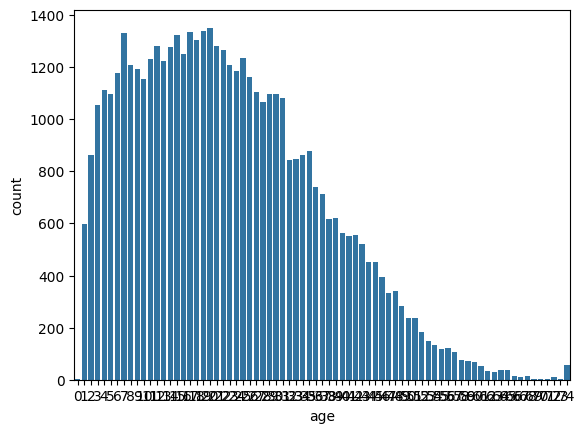

In [25]:
sns.countplot(data=synth_data.df, x="age")

<Axes: xlabel='age', ylabel='count'>

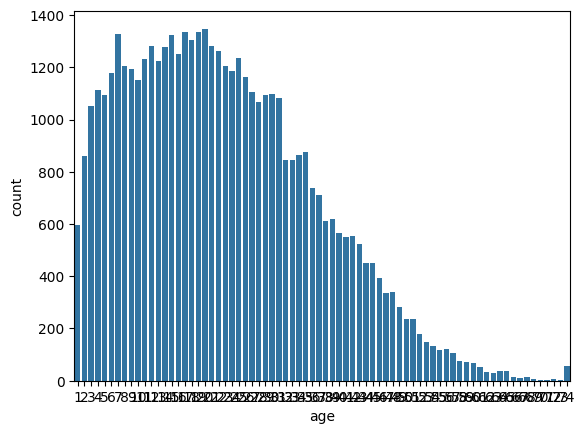

In [26]:
sns.countplot(data=data.df, x="age")

# Full implementation

In [ ]:
from mbi import Dataset, FactoredInference, Domain, LocalInference, PublicInference
import numpy as np
from scipy import sparse

# load adult dataset

data = Dataset.load('./data/adult.csv', './data/adult-domain.json')
domain = data.domain
total = data.df.shape[0]

print(domain)

# spend half of privacy budget to measure all 1 way marginals
np.random.seed(0)

cliques = [('age', 'education-num'), 
            ('marital-status', 'race'), 
            ('sex', 'hours-per-week'),
            ('hours-per-week', 'income>50K'),
            ('native-country', 'marital-status', 'occupation')]

epsilon = 1.0
epsilon_split = epsilon / (len(data.domain) + len(cliques))
sigma = 2.0 / epsilon_split

measurements = []
for col in data.domain:
    x = data.project(col).datavector()
    y = x + np.random.laplace(loc=0, scale=sigma, size=x.size)
    I = sparse.eye(x.size)
    measurements.append( (I, y, sigma, (col,)) )

# spend half of privacy budget to measure some more 2 and 3 way marginals



for cl in cliques:
    x = data.project(cl).datavector()
    y = x + np.random.laplace(loc=0, scale=sigma, size=x.size)
    I = sparse.eye(x.size)
    measurements.append( (I, y, sigma, cl) )

# now perform inference to estimate the data distribution
# We can either use Private-PGM (FactoredInference) or 
# Approx-Private-PGM (LocalInference), both share the same interface.

engine = FactoredInference(domain, log=True, iters=2500)
#engine = LocalInference(domain, log=True, iters=2500, marginal_oracle='convex')

model = engine.estimate(measurements, total=total)

# now answer new queries

y1 = model.project(('sex', 'income>50K')).datavector()
y2 = model.project(('race', 'occupation')).datavector()

In [13]:
new_dataset = model.synthetic_data()

In [15]:
new_dataset.df

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income>50K
0,24,0,12,8,4,8,1,4,1,0,0,44,0,0
1,25,4,10,9,1,9,3,0,1,0,0,49,0,1
2,30,0,17,12,2,2,2,0,0,0,0,37,0,0
3,28,0,3,12,0,5,1,0,0,0,0,24,0,0
4,45,0,53,8,3,10,2,0,0,0,0,34,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,13,8,9,12,0,4,1,0,0,0,0,39,0,0
48838,39,0,8,8,1,11,0,0,1,0,0,49,0,1
48839,7,4,1,9,0,4,3,1,0,0,0,24,0,0
48840,13,0,1,10,3,8,2,0,1,0,0,44,0,0


<Axes: xlabel='age', ylabel='count'>

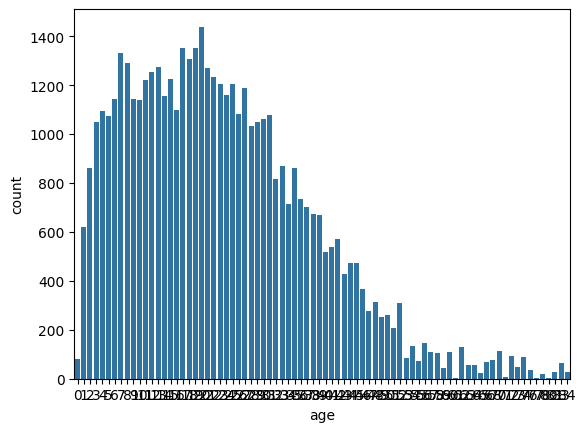

In [16]:
sns.countplot(data=new_dataset.df, x="age")

<Axes: xlabel='age', ylabel='count'>

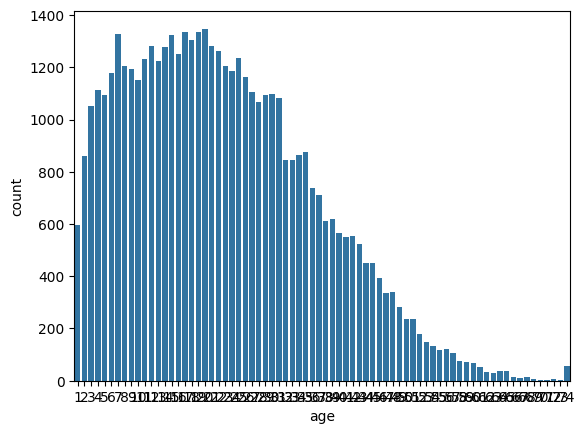

In [18]:
sns.countplot(data=data.df, x="age")